In [1]:
import glob

import scipy
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
def get_latest_output_dir(reward, strategy, policy_cls, index=-1):
    output_dir = sorted(glob.glob(f"../records/{reward}/{strategy}/{policy_cls}/*"))[index]
    return output_dir


def plot_metrics(train_reward, valid_reward, strategy, policy_cls, scale=1, ann_scaler=252, norm_steps_per_episode=False, index=-1):
    
    output_dir = get_latest_output_dir(train_reward, strategy, policy_cls, index)
    
    df_base = pd.read_csv(f"{output_dir}/baseline/result.csv")
    df_train = pd.read_csv(f"{output_dir}/metrics/train_result.csv", index_col=0)
    df_valid_train = pd.read_csv(f"{output_dir}/metrics/validation_train_result.csv", index_col=0)
    df_valid = pd.read_csv(f"{output_dir}/metrics/validation_result.csv", index_col=0)
    df_base = df_base.loc[df_base.index.repeat(len(df_train))].reset_index(drop=True)

    df_train["reward"] = df_train["reward"] / scale * ann_scaler
    
    if norm_steps_per_episode:
        df_train["reward"] = df_train["reward"] / df_train["steps_per_episode"]
    
    df = pd.DataFrame({
        "baseline": df_base["reward"],
        "train": df_train["reward"],
        "valid_train": df_valid_train["val_train/reward"],
        "valid": df_valid["val/reward"]
    })
    df.dropna(inplace=True)
    
    print(f"Loaded metrics from: {output_dir}")
    best = df.fillna(-1).sort_values("valid", ascending=True).iloc[-1].to_dict()
    print(best)
    print(scipy.stats.spearmanr(df["valid_train"], df["valid"]))
    print(df)
    
    df.plot(figsize=(10, 6))
    plt.legend([f"baseline ({best['baseline']:.5f})", f"train ({best['train']:.5f})", f"valid_train ({best['valid_train']:.5f})", f"valid ({best['valid']:.5f})"])
    plt.title(f"{strategy} ({policy_cls})")
    plt.xlabel("Episode")
    plt.ylabel(train_reward)

Loaded metrics from: ../records/ExecutionExcessMeanVarianceReward/TopkDropoutContinuousRerankStrategy/MetaPPO/2023_03_26_13_55
{'baseline': 1.6025939882073692, 'train': 0.5346531086975258, 'valid_train': 2.396520240923448, 'valid': 1.1085653902782897}
SpearmanrResult(correlation=0.08179511853731082, pvalue=0.5008491878162669)
    baseline     train  valid_train     valid
0   1.602594  0.498396     2.601061 -0.033789
1   1.602594  0.446593     1.459281  0.095696
2   1.602594  0.420212     1.817291  0.409876
3   1.602594  0.445084     1.433288  0.306050
4   1.602594  0.470092     2.068270  0.431908
..       ...       ...          ...       ...
65  1.602594  0.505060     1.591901 -0.006968
66  1.602594  0.418534     1.538135  0.074211
67  1.602594  0.432342     1.836023  0.027716
68  1.602594  0.474927     1.488511  0.375102
69  1.602594  0.473461     1.515741  0.258362

[70 rows x 4 columns]


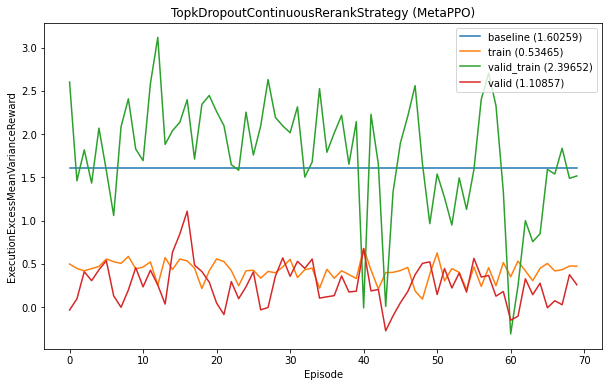

In [3]:
plot_metrics(
    train_reward="ExecutionExcessMeanVarianceReward",
    valid_reward="EpisodeInformationRatioReward",
    strategy="TopkDropoutContinuousRerankStrategy",
    policy_cls="MetaPPO",
    scale=1,
    ann_scaler=1,
    norm_steps_per_episode=False,
    index=-1
)

Loaded metrics from: ../records/ExecutionExcessMeanVarianceReward/TopkDropoutContinuousRerankDynamicParamStrategy/MetaPPO/2023_03_26_13_56
{'baseline': 1.6025939882073683, 'train': 0.3610270513558434, 'valid_train': 0.3200157979318619, 'valid': 1.0849812635511868}
SpearmanrResult(correlation=0.20821901408784407, pvalue=0.0908636378806131)
    baseline     train  valid_train     valid
0   1.602594  0.340433     0.357370  0.636420
1   1.602594  0.486677    -0.229632  0.428956
2   1.602594  0.494650    -0.078305  0.391458
3   1.602594  0.544557     0.301394  0.643971
4   1.602594  0.353570    -0.174762  0.908891
..       ...       ...          ...       ...
62  1.602594  0.312318     1.643473  0.988006
63  1.602594  0.579676     1.714581  1.015329
64  1.602594  0.428533     1.695371  0.981275
65  1.602594  0.553662     1.285392  0.896155
66  1.602594  0.520585     1.160869  0.960008

[67 rows x 4 columns]


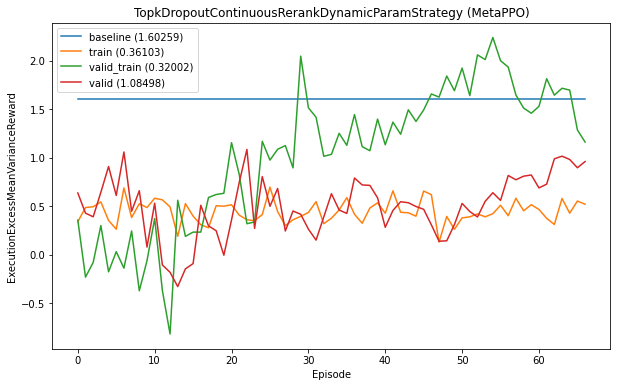

In [4]:
plot_metrics(
    train_reward="ExecutionExcessMeanVarianceReward",
    valid_reward="EpisodeInformationRatioReward",
    strategy="TopkDropoutContinuousRerankDynamicParamStrategy",
    policy_cls="MetaPPO",
    scale=1,
    ann_scaler=1,
    norm_steps_per_episode=False,
    index=-1
)

Loaded metrics from: ../records/ExecutionExcessMeanVarianceReward/TopkDropoutDiscreteDynamicParamStrategy/PPO/2023_03_26_16_28
{'baseline': 1.6025939882073688, 'train': 0.610486247189091, 'valid_train': 3.0612677151190364, 'valid': 1.6510573724737183}
SpearmanrResult(correlation=-0.29928296974179364, pvalue=0.08552473727918897)
    baseline     train  valid_train     valid
0   1.602594  0.998762     3.510136  1.306997
1   1.602594  0.870148     3.510136  1.306997
2   1.602594  0.967174     3.510136  1.306997
3   1.602594  0.933074     3.510136  1.304024
4   1.602594  0.824460     3.510136  1.318165
5   1.602594  0.728301     3.184403  1.347419
6   1.602594  0.790979     3.176261  1.308383
7   1.602594  0.768150     3.176261  1.304888
8   1.602594  0.712167     3.176261  1.304888
9   1.602594  0.708081     3.138711  1.589166
10  1.602594  0.610486     3.061268  1.651057
11  1.602594  0.812005     3.061268  1.635205
12  1.602594  0.832856     3.580666  1.331401
13  1.602594  0.800779    

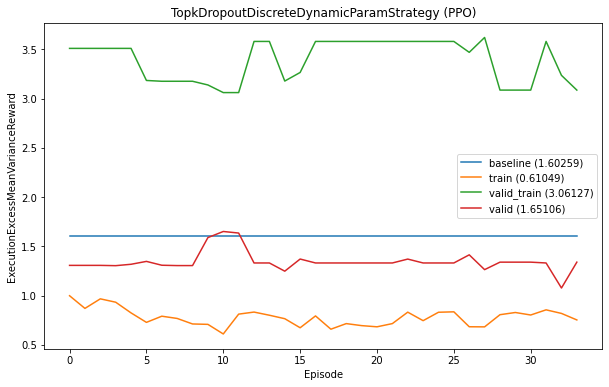

In [5]:
plot_metrics(
    train_reward="ExecutionExcessMeanVarianceReward",
    valid_reward="EpisodeInformationRatioReward",
    strategy="TopkDropoutDiscreteDynamicParamStrategy",
    policy_cls="PPO",
    scale=1,
    ann_scaler=1,
    norm_steps_per_episode=False,
    index=-1
)

Loaded metrics from: ../records/ExecutionExcessMeanVarianceReward/TopkDropoutDiscreteDynamicSelectionStrategy/PPO/2023_03_26_15_36
{'baseline': 1.602593988207369, 'train': 0.4515775315655939, 'valid_train': 2.1176440110814947, 'valid': 1.7879930571822766}
SpearmanrResult(correlation=-0.0754267856821873, pvalue=0.6143355020298061)
    baseline     train  valid_train     valid
0   1.602594  0.303340     0.615482  0.266342
1   1.602594  0.437867    -0.046403  0.128390
2   1.602594  0.437123     0.976449  0.932922
3   1.602594  0.455756     0.976449  0.701955
4   1.602594  0.467746     0.976449  0.635132
5   1.602594  0.539391     0.976449  1.092967
6   1.602594  0.379185     0.976449  0.635132
7   1.602594  0.469487     0.976449  0.635132
8   1.602594  0.285225     0.976449  0.807715
9   1.602594  0.595872     1.941836  1.385404
10  1.602594  0.581606     2.117644  1.787993
11  1.602594  0.282462     2.518082  1.054100
12  1.602594  0.240965     2.593384  0.856730
13  1.602594  0.812210  

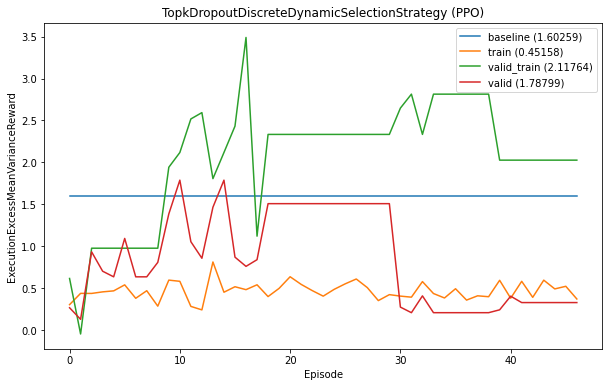

In [6]:
plot_metrics(
    train_reward="ExecutionExcessMeanVarianceReward",
    valid_reward="EpisodeInformationRatioReward",
    strategy="TopkDropoutDiscreteDynamicSelectionStrategy",
    policy_cls="PPO",
    scale=1,
    ann_scaler=1,
    norm_steps_per_episode=False,
    index=-1
)

Loaded metrics from: ../records/ExecutionExcessMeanVarianceReward/TopkDropoutDiscreteRerankDynamicParamStrategy/MetaPPO/2023_03_27_22_20
{'baseline': 1.605670875611319, 'train': 0.2891895825942885, 'valid_train': 1.1040290786639608, 'valid': 1.1433729157523784}
SpearmanrResult(correlation=0.24871001031991744, pvalue=0.31964521777772886)
    baseline     train  valid_train     valid
0   1.605671  0.662742     1.916887  0.367627
1   1.605671  0.629036     1.466097  0.218956
2   1.605671  0.163610     0.974377  0.286281
3   1.605671  0.698975     1.568391  0.375868
4   1.605671  0.552331     0.990665  0.745663
5   1.605671  0.517963     1.618925  0.285594
6   1.605671  0.348746     0.990236  0.668027
7   1.605671  0.289190     1.104029  1.143373
8   1.605671  0.464232     1.428473  0.560518
9   1.605671  0.340325     1.741515  0.640780
10  1.605671  0.287257     2.235585  0.262117
11  1.605671  0.570093     2.392365  0.648278
12  1.605671  0.531060     2.606473  0.748848
13  1.605671  0.5

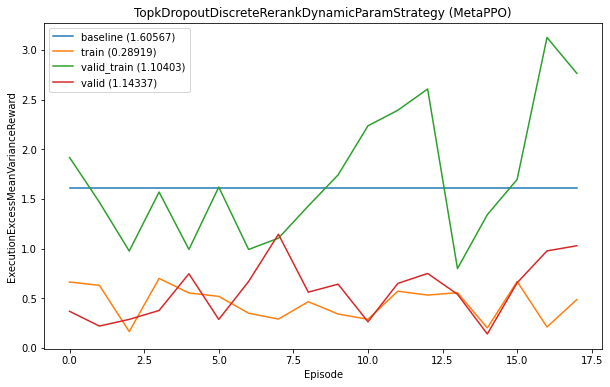

In [7]:
plot_metrics(
    train_reward="ExecutionExcessMeanVarianceReward",
    valid_reward="EpisodeInformationRatioReward",
    strategy="TopkDropoutDiscreteRerankDynamicParamStrategy",
    policy_cls="MetaPPO",
    scale=1,
    ann_scaler=1,
    norm_steps_per_episode=False,
    index=-1
)